# Computation on NumPy Arrays: Universal Functions

Up until now, we have been discussing some of the basic nuts and bolts of NumPy; in the next few sections, we will dive into the reasons that NumPy is so important in the Python data science world.
Namely, it provides an easy and flexible interface to optimized computation with arrays of data.

Computation on NumPy arrays can be very fast, or it can be very slow.
The key to making it fast is to use *vectorized* operations, generally implemented through NumPy's *universal functions* (ufuncs).
This section motivates the need for NumPy's ufuncs, which can be used to make repeated calculations on array elements much more efficient.
It then introduces many of the most common and useful arithmetic ufuncs available in the NumPy package.

## The Slowness of Loops

Python's default implementation (known as CPython) does some operations very slowly.
This is in part due to the dynamic, interpreted nature of the language: the fact that types are flexible, so that sequences of operations cannot be compiled down to efficient machine code as in languages like C and Fortran.
Recently there have been various attempts to address this weakness: well-known examples are the [PyPy](http://pypy.org/) project, a just-in-time compiled implementation of Python; the [Cython](http://cython.org) project, which converts Python code to compilable C code; and the [Numba](http://numba.pydata.org/) project, which converts snippets of Python code to fast LLVM bytecode.
Each of these has its strengths and weaknesses, but it is safe to say that none of the three approaches has yet surpassed the reach and popularity of the standard CPython engine.

The relative sluggishness of Python generally manifests itself in situations where many small operations are being repeated – for instance looping over arrays to operate on each element.
For example, imagine we have an array of values and we'd like to compute the reciprocal of each.
A straightforward approach might look like this:

In [1]:
import numpy as np
np.random.seed(0)

def compute_reciprocals(values):
    output = np.empty(len(values))
    for i in range(len(values)):
        output[i] = 1.0 / values[i]
    return output
        
values = np.random.randint(1, 10, size=5)
print(values)
compute_reciprocals(values)

[6 1 4 4 8]


array([0.16666667, 1.        , 0.25      , 0.25      , 0.125     ])

This implementation probably feels fairly natural to someone from, say, a C or Java background.
But if we measure the execution time of this code for a large input, we see that this operation is very slow, perhaps surprisingly so!
We'll benchmark this with IPython's ``%timeit`` magic (discussed in [Profiling and Timing Code](01.07-Timing-and-Profiling.ipynb)):

In [2]:
big_array = np.random.randint(1, 100, size=1000000)
%timeit compute_reciprocals(big_array)

2.19 s ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It takes several seconds to compute these million operations and to store the result!
When even cell phones have processing speeds measured in Giga-FLOPS (i.e., billions of numerical operations per second), this seems almost absurdly slow.
It turns out that the bottleneck here is not the operations themselves, but the type-checking and function dispatches that CPython must do at each cycle of the loop.
Each time the reciprocal is computed, Python first examines the object's type and does a dynamic lookup of the correct function to use for that type.
If we were working in compiled code instead, this type specification would be known before the code executes and the result could be computed much more efficiently.

## Introducing UFuncs

For many types of operations, NumPy provides a convenient interface into just this kind of statically typed, compiled routine. This is known as a *vectorized* operation.
This can be accomplished by simply performing an operation on the array, which will then be applied to each element.
This vectorized approach is designed to push the loop into the compiled layer that underlies NumPy, leading to much faster execution.

Compare the results of the following two:

In [3]:
print(compute_reciprocals(values))
print(1.0 / values)

[0.16666667 1.         0.25       0.25       0.125     ]
[0.16666667 1.         0.25       0.25       0.125     ]


Looking at the execution time for our big array, we see that it completes orders of magnitude faster than the Python loop:

In [4]:
%timeit (1.0 / big_array)

4.7 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Vectorized operations in NumPy are implemented via *ufuncs*, whose main purpose is to quickly execute repeated operations on values in NumPy arrays.
Ufuncs are extremely flexible – before we saw an operation between a scalar and an array, but we can also operate between two arrays:

In [5]:
np.arange(5) / np.arange(1, 6)

array([0.        , 0.5       , 0.66666667, 0.75      , 0.8       ])

And ufunc operations are not limited to one-dimensional arrays–they can also act on multi-dimensional arrays as well:

In [6]:
x = np.arange(9).reshape((3, 3))
2 ** x

array([[  1,   2,   4],
       [  8,  16,  32],
       [ 64, 128, 256]], dtype=int32)

Computations using vectorization through ufuncs are nearly always more efficient than their counterpart implemented using Python loops, especially as the arrays grow in size.
Any time you see such a loop in a Python script, you should consider whether it can be replaced with a vectorized expression.

## Exploring NumPy's UFuncs

Ufuncs exist in two flavors: *unary ufuncs*, which operate on a single input, and *binary ufuncs*, which operate on two inputs.
We'll see examples of both these types of functions here.

### Array arithmetic

NumPy's ufuncs feel very natural to use because they make use of Python's native arithmetic operators.
The standard addition, subtraction, multiplication, and division can all be used:

In [7]:
x = np.arange(4)
print("x     =", x)
print("x + 5 =", x + 5)
print("x - 5 =", x - 5)
print("x * 2 =", x * 2)
print("x / 2 =", x / 2)
print("x // 2 =", x // 2)  # floor division

x     = [0 1 2 3]
x + 5 = [5 6 7 8]
x - 5 = [-5 -4 -3 -2]
x * 2 = [0 2 4 6]
x / 2 = [0.  0.5 1.  1.5]
x // 2 = [0 0 1 1]


There is also a unary ufunc for negation, and a ``**`` operator for exponentiation, and a ``%`` operator for modulus:

In [8]:
print("-x     = ", -x)
print("x ** 2 = ", x ** 2)
print("x % 2  = ", x % 2)

-x     =  [ 0 -1 -2 -3]
x ** 2 =  [0 1 4 9]
x % 2  =  [0 1 0 1]


In addition, these can be strung together however you wish, and the standard order of operations is respected:

In [9]:
-(0.5*x + 1) ** 2

array([-1.  , -2.25, -4.  , -6.25])

Each of these arithmetic operations are simply convenient wrappers around specific functions built into NumPy; for example, the ``+`` operator is a wrapper for the ``add`` function:

In [10]:
np.add(x, 2)

array([2, 3, 4, 5])

The following table lists the arithmetic operators implemented in NumPy:

| Operator	    | Equivalent ufunc    | Description                           |
|---------------|---------------------|---------------------------------------|
|``+``          |``np.add``           |Addition (e.g., ``1 + 1 = 2``)         |
|``-``          |``np.subtract``      |Subtraction (e.g., ``3 - 2 = 1``)      |
|``-``          |``np.negative``      |Unary negation (e.g., ``-2``)          |
|``*``          |``np.multiply``      |Multiplication (e.g., ``2 * 3 = 6``)   |
|``/``          |``np.divide``        |Division (e.g., ``3 / 2 = 1.5``)       |
|``//``         |``np.floor_divide``  |Floor division (e.g., ``3 // 2 = 1``)  |
|``**``         |``np.power``         |Exponentiation (e.g., ``2 ** 3 = 8``)  |
|``%``          |``np.mod``           |Modulus/remainder (e.g., ``9 % 4 = 1``)|

Additionally there are Boolean/bitwise operators; we will explore these in [Comparisons, Masks, and Boolean Logic](02.06-Boolean-Arrays-and-Masks.ipynb).

### Absolute value

Just as NumPy understands Python's built-in arithmetic operators, it also understands Python's built-in absolute value function:

In [11]:
x = np.array([-2, -1, 0, 1, 2])
abs(x)

array([2, 1, 0, 1, 2])

The corresponding NumPy ufunc is ``np.absolute``, which is also available under the alias ``np.abs``:

In [12]:
np.absolute(x)

array([2, 1, 0, 1, 2])

In [13]:
np.abs(x)

array([2, 1, 0, 1, 2])

This ufunc can also handle complex data, in which the absolute value returns the magnitude:

In [14]:
x = np.array([3 - 4j, 4 - 3j, 2 + 0j, 0 + 1j])
np.abs(x)

array([5., 5., 2., 1.])

### Trigonometric functions

NumPy provides a large number of useful ufuncs, and some of the most useful for the data scientist are the trigonometric functions.
We'll start by defining an array of angles:

In [15]:
theta = np.linspace(0, np.pi, 3)

Now we can compute some trigonometric functions on these values:

In [16]:
print("theta      = ", theta)
print("sin(theta) = ", np.sin(theta))
print("cos(theta) = ", np.cos(theta))
print("tan(theta) = ", np.tan(theta))

theta      =  [0.         1.57079633 3.14159265]
sin(theta) =  [0.0000000e+00 1.0000000e+00 1.2246468e-16]
cos(theta) =  [ 1.000000e+00  6.123234e-17 -1.000000e+00]
tan(theta) =  [ 0.00000000e+00  1.63312394e+16 -1.22464680e-16]


The values are computed to within machine precision, which is why values that should be zero do not always hit exactly zero.
Inverse trigonometric functions are also available:

In [17]:
x = [-1, 0, 1]
print("x         = ", x)
print("arcsin(x) = ", np.arcsin(x))
print("arccos(x) = ", np.arccos(x))
print("arctan(x) = ", np.arctan(x))

x         =  [-1, 0, 1]
arcsin(x) =  [-1.57079633  0.          1.57079633]
arccos(x) =  [3.14159265 1.57079633 0.        ]
arctan(x) =  [-0.78539816  0.          0.78539816]


### Exponents and logarithms

Another common type of operation available in a NumPy ufunc are the exponentials:

In [18]:
x = [1, 2, 3]
print("x     =", x)
print("e^x   =", np.exp(x))
print("2^x   =", np.exp2(x))
print("3^x   =", np.power(3, x))

x     = [1, 2, 3]
e^x   = [ 2.71828183  7.3890561  20.08553692]
2^x   = [2. 4. 8.]
3^x   = [ 3  9 27]


The inverse of the exponentials, the logarithms, are also available.
The basic ``np.log`` gives the natural logarithm; if you prefer to compute the base-2 logarithm or the base-10 logarithm, these are available as well:

In [19]:
x = [1, 2, 4, 10]
print("x        =", x)
print("ln(x)    =", np.log(x))
print("log2(x)  =", np.log2(x))
print("log10(x) =", np.log10(x))

x        = [1, 2, 4, 10]
ln(x)    = [0.         0.69314718 1.38629436 2.30258509]
log2(x)  = [0.         1.         2.         3.32192809]
log10(x) = [0.         0.30103    0.60205999 1.        ]


There are also some specialized versions that are useful for maintaining precision with very small input:

In [20]:
x = [0, 0.001, 0.01, 0.1]
print("exp(x) - 1 =", np.expm1(x))
print("log(1 + x) =", np.log1p(x))

exp(x) - 1 = [0.         0.0010005  0.01005017 0.10517092]
log(1 + x) = [0.         0.0009995  0.00995033 0.09531018]


When ``x`` is very small, these functions give more precise values than if the raw ``np.log`` or ``np.exp`` were to be used.

### Specialized ufuncs

NumPy has many more ufuncs available, including hyperbolic trig functions, bitwise arithmetic, comparison operators, conversions from radians to degrees, rounding and remainders, and much more.
A look through the NumPy documentation reveals a lot of interesting functionality.

Another excellent source for more specialized and obscure ufuncs is the submodule ``scipy.special``.
If you want to compute some obscure mathematical function on your data, chances are it is implemented in ``scipy.special``.
There are far too many functions to list them all, but the following snippet shows a couple that might come up in a statistics context:

In [21]:
from scipy import special

In [22]:
# Gamma functions (generalized factorials) and related functions
x = [1, 5, 10]
print("gamma(x)     =", special.gamma(x))
print("ln|gamma(x)| =", special.gammaln(x))
print("beta(x, 2)   =", special.beta(x, 2))

gamma(x)     = [1.0000e+00 2.4000e+01 3.6288e+05]
ln|gamma(x)| = [ 0.          3.17805383 12.80182748]
beta(x, 2)   = [0.5        0.03333333 0.00909091]


In [23]:
# Error function (integral of Gaussian)
# its complement, and its inverse
x = np.array([0, 0.3, 0.7, 1.0])
print("erf(x)  =", special.erf(x))
print("erfc(x) =", special.erfc(x))
print("erfinv(x) =", special.erfinv(x))

erf(x)  = [0.         0.32862676 0.67780119 0.84270079]
erfc(x) = [1.         0.67137324 0.32219881 0.15729921]
erfinv(x) = [0.         0.27246271 0.73286908        inf]


There are many, many more ufuncs available in both NumPy and ``scipy.special``.
Because the documentation of these packages is available online, a web search along the lines of "gamma function python" will generally find the relevant information.

## Advanced Ufunc Features

Many NumPy users make use of ufuncs without ever learning their full set of features.
We'll outline a few specialized features of ufuncs here.

### Specifying output

For large calculations, it is sometimes useful to be able to specify the array where the result of the calculation will be stored.
Rather than creating a temporary array, this can be used to write computation results directly to the memory location where you'd like them to be.
For all ufuncs, this can be done using the ``out`` argument of the function:

In [24]:
x = np.arange(5)
y = np.empty(5)
np.multiply(x, 10, out=y)
print(y)

[ 0. 10. 20. 30. 40.]


This can even be used with array views. For example, we can write the results of a computation to every other element of a specified array:

In [25]:
y = np.zeros(10)
np.power(2, x, out=y[::2])
print(y)

[ 1.  0.  2.  0.  4.  0.  8.  0. 16.  0.]


If we had instead written ``y[::2] = 2 ** x``, this would have resulted in the creation of a temporary array to hold the results of ``2 ** x``, followed by a second operation copying those values into the ``y`` array.
This doesn't make much of a difference for such a small computation, but for very large arrays the memory savings from careful use of the ``out`` argument can be significant.

### Aggregates

For binary ufuncs, there are some interesting aggregates that can be computed directly from the object.
For example, if we'd like to *reduce* an array with a particular operation, we can use the ``reduce`` method of any ufunc.
A reduce repeatedly applies a given operation to the elements of an array until only a single result remains.

For example, calling ``reduce`` on the ``add`` ufunc returns the sum of all elements in the array:

In [26]:
x = np.arange(1, 6)
np.add.reduce(x)

15

Similarly, calling ``reduce`` on the ``multiply`` ufunc results in the product of all array elements:

In [27]:
np.multiply.reduce(x)

120

If we'd like to store all the intermediate results of the computation, we can instead use ``accumulate``:

In [28]:
np.add.accumulate(x)

array([ 1,  3,  6, 10, 15], dtype=int32)

In [29]:
np.multiply.accumulate(x)

array([  1,   2,   6,  24, 120], dtype=int32)

Note that for these particular cases, there are dedicated NumPy functions to compute the results (``np.sum``, ``np.prod``, ``np.cumsum``, ``np.cumprod``), which we'll explore in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb).

### Outer products

Finally, any ufunc can compute the output of all pairs of two different inputs using the ``outer`` method.
This allows you, in one line, to do things like create a multiplication table:

In [30]:
x = np.arange(1, 6)
np.multiply.outer(x, x)

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20],
       [ 5, 10, 15, 20, 25]])

The ``ufunc.at`` and ``ufunc.reduceat`` methods, which we'll explore in [Fancy Indexing](02.07-Fancy-Indexing.ipynb), are very helpful as well.

Another extremely useful feature of ufuncs is the ability to operate between arrays of different sizes and shapes, a set of operations known as *broadcasting*.
This subject is important enough that we will devote a whole section to it (see [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb)).

## Ufuncs: Learning More

More information on universal functions (including the full list of available functions) can be found on the [NumPy](http://www.numpy.org) and [SciPy](http://www.scipy.org) documentation websites.

Recall that you can also access information directly from within IPython by importing the packages and using IPython's tab-completion and help (``?``) functionality, as described in [Help and Documentation in IPython](01.01-Help-And-Documentation.ipynb).

# Computation on Arrays: Broadcasting

We saw in the previous section how NumPy's universal functions can be used to *vectorize* operations and thereby remove slow Python loops.
Another means of vectorizing operations is to use NumPy's *broadcasting* functionality.
Broadcasting is simply a set of rules for applying binary ufuncs (e.g., addition, subtraction, multiplication, etc.) on arrays of different sizes.

## Introducing Broadcasting

Recall that for arrays of the same size, binary operations are performed on an element-by-element basis:

In [31]:
import numpy as np

In [32]:
a = np.array([0, 1, 2])
b = np.array([5, 5, 5])
a + b

array([5, 6, 7])

Broadcasting allows these types of binary operations to be performed on arrays of different sizes–for example, we can just as easily add a scalar (think of it as a zero-dimensional array) to an array:

In [33]:
a + 5

array([5, 6, 7])

We can think of this as an operation that stretches or duplicates the value ``5`` into the array ``[5, 5, 5]``, and adds the results.
The advantage of NumPy's broadcasting is that this duplication of values does not actually take place, but it is a useful mental model as we think about broadcasting.

We can similarly extend this to arrays of higher dimension. Observe the result when we add a one-dimensional array to a two-dimensional array:

In [34]:
M = np.ones((3, 3))
M

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [35]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

Here the one-dimensional array ``a`` is stretched, or broadcast across the second dimension in order to match the shape of ``M``.

While these examples are relatively easy to understand, more complicated cases can involve broadcasting of both arrays. Consider the following example:

In [36]:
a = np.arange(3)
b = np.arange(3)[:, np.newaxis]

print(a)
print(b)

[0 1 2]
[[0]
 [1]
 [2]]


In [37]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

Just as before we stretched or broadcasted one value to match the shape of the other, here we've stretched *both* ``a`` and ``b`` to match a common shape, and the result is a two-dimensional array!
The geometry of these examples is visualized in the following figure (Code to produce this plot can be found in the [appendix](06.00-Figure-Code.ipynb#Broadcasting), and is adapted from source published in the [astroML](http://astroml.org) documentation. Used by permission).

![Broadcasting Visual](figures/02.05-broadcasting.png)

The light boxes represent the broadcasted values: again, this extra memory is not actually allocated in the course of the operation, but it can be useful conceptually to imagine that it is.

## Rules of Broadcasting

Broadcasting in NumPy follows a strict set of rules to determine the interaction between the two arrays:

- Rule 1: If the two arrays differ in their number of dimensions, the shape of the one with fewer dimensions is *padded* with ones on its leading (left) side.
- Rule 2: If the shape of the two arrays does not match in any dimension, the array with shape equal to 1 in that dimension is stretched to match the other shape.
- Rule 3: If in any dimension the sizes disagree and neither is equal to 1, an error is raised.

To make these rules clear, let's consider a few examples in detail.

### Broadcasting example 1

Let's look at adding a two-dimensional array to a one-dimensional array:

In [38]:
M = np.ones((2, 3))
a = np.arange(3)

Let's consider an operation on these two arrays. The shape of the arrays are

- ``M.shape = (2, 3)``
- ``a.shape = (3,)``

We see by rule 1 that the array ``a`` has fewer dimensions, so we pad it on the left with ones:

- ``M.shape -> (2, 3)``
- ``a.shape -> (1, 3)``

By rule 2, we now see that the first dimension disagrees, so we stretch this dimension to match:

- ``M.shape -> (2, 3)``
- ``a.shape -> (2, 3)``

The shapes match, and we see that the final shape will be ``(2, 3)``:

In [39]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.]])

### Broadcasting example 2

Let's take a look at an example where both arrays need to be broadcast:

In [40]:
a = np.arange(3).reshape((3, 1))
b = np.arange(3)

Again, we'll start by writing out the shape of the arrays:

- ``a.shape = (3, 1)``
- ``b.shape = (3,)``

Rule 1 says we must pad the shape of ``b`` with ones:

- ``a.shape -> (3, 1)``
- ``b.shape -> (1, 3)``

And rule 2 tells us that we upgrade each of these ones to match the corresponding size of the other array:

- ``a.shape -> (3, 3)``
- ``b.shape -> (3, 3)``

Because the result matches, these shapes are compatible. We can see this here:

In [41]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

### Broadcasting example 3

Now let's take a look at an example in which the two arrays are not compatible:

In [42]:
M = np.ones((3, 2))
a = np.arange(3)

This is just a slightly different situation than in the first example: the matrix ``M`` is transposed.
How does this affect the calculation? The shape of the arrays are

- ``M.shape = (3, 2)``
- ``a.shape = (3,)``

Again, rule 1 tells us that we must pad the shape of ``a`` with ones:

- ``M.shape -> (3, 2)``
- ``a.shape -> (1, 3)``

By rule 2, the first dimension of ``a`` is stretched to match that of ``M``:

- ``M.shape -> (3, 2)``
- ``a.shape -> (3, 3)``

Now we hit rule 3–the final shapes do not match, so these two arrays are incompatible, as we can observe by attempting this operation:

In [43]:
M + a

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

Note the potential confusion here: you could imagine making ``a`` and ``M`` compatible by, say, padding ``a``'s shape with ones on the right rather than the left.
But this is not how the broadcasting rules work!
That sort of flexibility might be useful in some cases, but it would lead to potential areas of ambiguity.
If right-side padding is what you'd like, you can do this explicitly by reshaping the array (we'll use the ``np.newaxis`` keyword introduced in [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb)):

In [44]:
a[:, np.newaxis].shape

(3, 1)

In [45]:
M + a[:, np.newaxis]

array([[1., 1.],
       [2., 2.],
       [3., 3.]])

Also note that while we've been focusing on the ``+`` operator here, these broadcasting rules apply to *any* binary ``ufunc``.
For example, here is the ``logaddexp(a, b)`` function, which computes ``log(exp(a) + exp(b))`` with more precision than the naive approach:

In [46]:
np.logaddexp(M, a[:, np.newaxis])

array([[1.31326169, 1.31326169],
       [1.69314718, 1.69314718],
       [2.31326169, 2.31326169]])

For more information on the many available universal functions, refer to [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb).

## Broadcasting in Practice

Broadcasting operations form the core of many examples we'll see throughout this book.
We'll now take a look at a couple simple examples of where they can be useful.

### Centering an array

In the previous section, we saw that ufuncs allow a NumPy user to remove the need to explicitly write slow Python loops. Broadcasting extends this ability.
One commonly seen example is when centering an array of data.
Imagine you have an array of 10 observations, each of which consists of 3 values.
Using the standard convention (see [Data Representation in Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb#Data-Representation-in-Scikit-Learn)), we'll store this in a $10 \times 3$ array:

In [47]:
X = np.random.random((10, 3))

We can compute the mean of each feature using the ``mean`` aggregate across the first dimension:

In [48]:
Xmean = X.mean(0)
Xmean

array([0.40647027, 0.44407459, 0.36398265])

And now we can center the ``X`` array by subtracting the mean (this is a broadcasting operation):

In [49]:
X_centered = X - Xmean

To double-check that we've done this correctly, we can check that the centered array has near zero mean:

In [50]:
X_centered.mean(0)

array([-8.8817842e-17, -4.4408921e-17, -4.4408921e-17])

To within machine precision, the mean is now zero.

### Plotting a two-dimensional function

One place that broadcasting is very useful is in displaying images based on two-dimensional functions.
If we want to define a function $z = f(x, y)$, broadcasting can be used to compute the function across the grid:

In [51]:
# x and y have 50 steps from 0 to 5
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)[:, np.newaxis]

z = np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

We'll use Matplotlib to plot this two-dimensional array (these tools will be discussed in full in [Density and Contour Plots](04.04-Density-and-Contour-Plots.ipynb)):

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

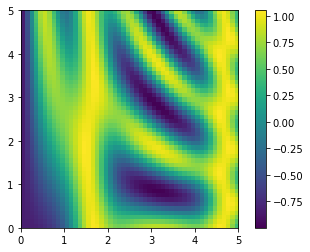

In [53]:
plt.imshow(z, origin='lower', extent=[0, 5, 0, 5],
           cmap='viridis')
plt.colorbar();

# Comparisons, Masks, and Boolean Logic

This section covers the use of Boolean masks to examine and manipulate values within NumPy arrays.
Masking comes up when you want to extract, modify, count, or otherwise manipulate values in an array based on some criterion: for example, you might wish to count all values greater than a certain value, or perhaps remove all outliers that are above some threshold.
In NumPy, Boolean masking is often the most efficient way to accomplish these types of tasks.

## Example: Counting Rainy Days

Imagine you have a series of data that represents the amount of precipitation each day for a year in a given city.
For example, here we'll load the daily rainfall statistics for the city of Seattle in 2014, using Pandas (which is covered in more detail in [Chapter 3](03.00-Introduction-to-Pandas.ipynb)):

In [54]:
import numpy as np
import pandas as pd

# use pandas to extract rainfall inches as a NumPy array
rainfall = pd.read_csv('data/Seattle2014.csv')['PRCP'].values
inches = rainfall / 254.0  # 1/10mm -> inches
inches.shape

(365,)

The array contains 365 values, giving daily rainfall in inches from January 1 to December 31, 2014.

As a first quick visualization, let's look at the histogram of rainy days, which was generated using Matplotlib (we will explore this tool more fully in [Chapter 4](04.00-Introduction-To-Matplotlib.ipynb)):

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # set plot styles

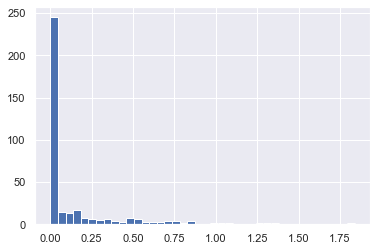

In [56]:
plt.hist(inches, 40);

This histogram gives us a general idea of what the data looks like: despite its reputation, the vast majority of days in Seattle saw near zero measured rainfall in 2014.
But this doesn't do a good job of conveying some information we'd like to see: for example, how many rainy days were there in the year? What is the average precipitation on those rainy days? How many days were there with more than half an inch of rain?

### Digging into the data

One approach to this would be to answer these questions by hand: loop through the data, incrementing a counter each time we see values in some desired range.
For reasons discussed throughout this chapter, such an approach is very inefficient, both from the standpoint of time writing code and time computing the result.
We saw in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) that NumPy's ufuncs can be used in place of loops to do fast element-wise arithmetic operations on arrays; in the same way, we can use other ufuncs to do element-wise *comparisons* over arrays, and we can then manipulate the results to answer the questions we have.
We'll leave the data aside for right now, and discuss some general tools in NumPy to use *masking* to quickly answer these types of questions.

## Comparison Operators as ufuncs

In [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) we introduced ufuncs, and focused in particular on arithmetic operators. We saw that using ``+``, ``-``, ``*``, ``/``, and others on arrays leads to element-wise operations.
NumPy also implements comparison operators such as ``<`` (less than) and ``>`` (greater than) as element-wise ufuncs.
The result of these comparison operators is always an array with a Boolean data type.
All six of the standard comparison operations are available:

In [57]:
x = np.array([1, 2, 3, 4, 5])

In [58]:
x < 3  # less than

array([ True,  True, False, False, False])

In [59]:
x > 3  # greater than

array([False, False, False,  True,  True])

In [60]:
x <= 3  # less than or equal

array([ True,  True,  True, False, False])

In [61]:
x >= 3  # greater than or equal

array([False, False,  True,  True,  True])

In [62]:
x != 3  # not equal

array([ True,  True, False,  True,  True])

In [63]:
x == 3  # equal

array([False, False,  True, False, False])

It is also possible to do an element-wise comparison of two arrays, and to include compound expressions:

In [64]:
(2 * x) == (x ** 2)

array([False,  True, False, False, False])

As in the case of arithmetic operators, the comparison operators are implemented as ufuncs in NumPy; for example, when you write ``x < 3``, internally NumPy uses ``np.less(x, 3)``.
    A summary of the comparison operators and their equivalent ufunc is shown here:

| Operator	    | Equivalent ufunc    | Operator	   | Equivalent ufunc    |
|---------------|---------------------|---------------|---------------------|
|``==``         |``np.equal``         |``!=``         |``np.not_equal``     |
|``<``          |``np.less``          |``<=``         |``np.less_equal``    |
|``>``          |``np.greater``       |``>=``         |``np.greater_equal`` |

Just as in the case of arithmetic ufuncs, these will work on arrays of any size and shape.
Here is a two-dimensional example:

In [65]:
rng = np.random.RandomState(0)
x = rng.randint(10, size=(3, 4))
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

In [66]:
x < 6

array([[ True,  True,  True,  True],
       [False, False,  True,  True],
       [ True,  True, False, False]])

In each case, the result is a Boolean array, and NumPy provides a number of straightforward patterns for working with these Boolean results.

## Working with Boolean Arrays

Given a Boolean array, there are a host of useful operations you can do.
We'll work with ``x``, the two-dimensional array we created earlier.

In [67]:
print(x)

[[5 0 3 3]
 [7 9 3 5]
 [2 4 7 6]]


### Counting entries

To count the number of ``True`` entries in a Boolean array, ``np.count_nonzero`` is useful:

In [68]:
# how many values less than 6?
np.count_nonzero(x < 6)

8

We see that there are eight array entries that are less than 6.
Another way to get at this information is to use ``np.sum``; in this case, ``False`` is interpreted as ``0``, and ``True`` is interpreted as ``1``:

In [69]:
np.sum(x < 6)

8

The benefit of ``sum()`` is that like with other NumPy aggregation functions, this summation can be done along rows or columns as well:

In [70]:
# how many values less than 6 in each row?
np.sum(x < 6, axis=1)

array([4, 2, 2])

This counts the number of values less than 6 in each row of the matrix.

If we're interested in quickly checking whether any or all the values are true, we can use (you guessed it) ``np.any`` or ``np.all``:

In [71]:
# are there any values greater than 8?
np.any(x > 8)

True

In [72]:
# are there any values less than zero?
np.any(x < 0)

False

In [73]:
# are all values less than 10?
np.all(x < 10)

True

In [74]:
# are all values equal to 6?
np.all(x == 6)

False

``np.all`` and ``np.any`` can be used along particular axes as well. For example:

In [75]:
# are all values in each row less than 8?
np.all(x < 8, axis=1)

array([ True, False,  True])

Here all the elements in the first and third rows are less than 8, while this is not the case for the second row.

Finally, a quick warning: as mentioned in [Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb), Python has built-in ``sum()``, ``any()``, and ``all()`` functions. These have a different syntax than the NumPy versions, and in particular will fail or produce unintended results when used on multidimensional arrays. Be sure that you are using ``np.sum()``, ``np.any()``, and ``np.all()`` for these examples!

### Boolean operators

We've already seen how we might count, say, all days with rain less than four inches, or all days with rain greater than two inches.
But what if we want to know about all days with rain less than four inches and greater than one inch?
This is accomplished through Python's *bitwise logic operators*, ``&``, ``|``, ``^``, and ``~``.
Like with the standard arithmetic operators, NumPy overloads these as ufuncs which work element-wise on (usually Boolean) arrays.

For example, we can address this sort of compound question as follows:

In [76]:
np.sum((inches > 0.5) & (inches < 1))

29

So we see that there are 29 days with rainfall between 0.5 and 1.0 inches.

Note that the parentheses here are important–because of operator precedence rules, with parentheses removed this expression would be evaluated as follows, which results in an error:

``` python
inches > (0.5 & inches) < 1
```

Using the equivalence of *A AND B* and *NOT (NOT A OR NOT B)* (which you may remember if you've taken an introductory logic course), we can compute the same result in a different manner:

In [77]:
np.sum(~( (inches <= 0.5) | (inches >= 1) ))

29

Combining comparison operators and Boolean operators on arrays can lead to a wide range of efficient logical operations.

The following table summarizes the bitwise Boolean operators and their equivalent ufuncs:

| Operator	    | Equivalent ufunc    || Operator	    | Equivalent ufunc    |
|---------------|---------------------||---------------|---------------------|
|``&``          |``np.bitwise_and``   ||&#124;         |``np.bitwise_or``    |
|``^``          |``np.bitwise_xor``   ||``~``          |``np.bitwise_not``   |

Using these tools, we might start to answer the types of questions we have about our weather data.
Here are some examples of results we can compute when combining masking with aggregations:

In [78]:
print("Number days without rain:      ", np.sum(inches == 0))
print("Number days with rain:         ", np.sum(inches != 0))
print("Days with more than 0.5 inches:", np.sum(inches > 0.5))
print("Rainy days with < 0.2 inches  :", np.sum((inches > 0) &
                                                (inches < 0.2)))

Number days without rain:       215
Number days with rain:          150
Days with more than 0.5 inches: 37
Rainy days with < 0.2 inches  : 75


## Boolean Arrays as Masks

In the preceding section we looked at aggregates computed directly on Boolean arrays.
A more powerful pattern is to use Boolean arrays as masks, to select particular subsets of the data themselves.
Returning to our ``x`` array from before, suppose we want an array of all values in the array that are less than, say, 5:

In [79]:
x

array([[5, 0, 3, 3],
       [7, 9, 3, 5],
       [2, 4, 7, 6]])

We can obtain a Boolean array for this condition easily, as we've already seen:

In [80]:
x < 5

array([[False,  True,  True,  True],
       [False, False,  True, False],
       [ True,  True, False, False]])

Now to *select* these values from the array, we can simply index on this Boolean array; this is known as a *masking* operation:

In [81]:
x[x < 5]

array([0, 3, 3, 3, 2, 4])

What is returned is a one-dimensional array filled with all the values that meet this condition; in other words, all the values in positions at which the mask array is ``True``.

We are then free to operate on these values as we wish.
For example, we can compute some relevant statistics on our Seattle rain data:

In [82]:
# construct a mask of all rainy days
rainy = (inches > 0)

# construct a mask of all summer days (June 21st is the 172nd day)
days = np.arange(365)
summer = (days > 172) & (days < 262)

print("Median precip on rainy days in 2014 (inches):   ",
      np.median(inches[rainy]))
print("Median precip on summer days in 2014 (inches):  ",
      np.median(inches[summer]))
print("Maximum precip on summer days in 2014 (inches): ",
      np.max(inches[summer]))
print("Median precip on non-summer rainy days (inches):",
      np.median(inches[rainy & ~summer]))

Median precip on rainy days in 2014 (inches):    0.19488188976377951
Median precip on summer days in 2014 (inches):   0.0
Maximum precip on summer days in 2014 (inches):  0.8503937007874016
Median precip on non-summer rainy days (inches): 0.20078740157480315


By combining Boolean operations, masking operations, and aggregates, we can very quickly answer these sorts of questions for our dataset.

## Aside: Using the Keywords and/or Versus the Operators &/|

One common point of confusion is the difference between the keywords ``and`` and ``or`` on one hand, and the operators ``&`` and ``|`` on the other hand.
When would you use one versus the other?

The difference is this: ``and`` and ``or`` gauge the truth or falsehood of *entire object*, while ``&`` and ``|`` refer to *bits within each object*.

When you use ``and`` or ``or``, it's equivalent to asking Python to treat the object as a single Boolean entity.
In Python, all nonzero integers will evaluate as True. Thus:

In [83]:
bool(42), bool(0)

(True, False)

In [84]:
bool(42 and 0)

False

In [85]:
bool(42 or 0)

True

When you use ``&`` and ``|`` on integers, the expression operates on the bits of the element, applying the *and* or the *or* to the individual bits making up the number:

In [86]:
bin(42)

'0b101010'

In [87]:
bin(59)

'0b111011'

In [88]:
bin(42 & 59)

'0b101010'

In [89]:
bin(42 | 59)

'0b111011'

Notice that the corresponding bits of the binary representation are compared in order to yield the result.

When you have an array of Boolean values in NumPy, this can be thought of as a string of bits where ``1 = True`` and ``0 = False``, and the result of ``&`` and ``|`` operates similarly to above:

In [90]:
A = np.array([1, 0, 1, 0, 1, 0], dtype=bool)
B = np.array([1, 1, 1, 0, 1, 1], dtype=bool)
A | B

array([ True,  True,  True, False,  True,  True])

Using ``or`` on these arrays will try to evaluate the truth or falsehood of the entire array object, which is not a well-defined value:

In [91]:
A or B

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Similarly, when doing a Boolean expression on a given array, you should use ``|`` or ``&`` rather than ``or`` or ``and``:

In [92]:
x = np.arange(10)
(x > 4) & (x < 8)

array([False, False, False, False, False,  True,  True,  True, False,
       False])

Trying to evaluate the truth or falsehood of the entire array will give the same ``ValueError`` we saw previously:

In [93]:
(x > 4) and (x < 8)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

So remember this: ``and`` and ``or`` perform a single Boolean evaluation on an entire object, while ``&`` and ``|`` perform multiple Boolean evaluations on the content (the individual bits or bytes) of an object.
For Boolean NumPy arrays, the latter is nearly always the desired operation.

# Fancy Indexing

In the previous sections, we saw how to access and modify portions of arrays using simple indices (e.g., ``arr[0]``), slices (e.g., ``arr[:5]``), and Boolean masks (e.g., ``arr[arr > 0]``).
In this section, we'll look at another style of array indexing, known as *fancy indexing*.
Fancy indexing is like the simple indexing we've already seen, but we pass arrays of indices in place of single scalars.
This allows us to very quickly access and modify complicated subsets of an array's values.

## Exploring Fancy Indexing

Fancy indexing is conceptually simple: it means passing an array of indices to access multiple array elements at once.
For example, consider the following array:

In [16]:
import numpy as np
rand = np.random.RandomState(42)

x = rand.randint(100, size=10)
print(x)

[51 92 14 71 60 20 82 86 74 74]


Suppose we want to access three different elements. We could do it like this:

In [95]:
[x[3], x[7], x[2]]

[71, 86, 14]

Alternatively, we can pass a single list or array of indices to obtain the same result:

In [96]:
ind = [3, 7, 4]
x[ind]

array([71, 86, 60])

When using fancy indexing, the shape of the result reflects the shape of the *index arrays* rather than the shape of the *array being indexed*:

In [97]:
ind = np.array([[3, 7],
                [4, 5]])
x[ind]

array([[71, 86],
       [60, 20]])

Fancy indexing also works in multiple dimensions. Consider the following array:

In [98]:
X = np.arange(12).reshape((3, 4))
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

Like with standard indexing, the first index refers to the row, and the second to the column:

In [99]:
row = np.array([0, 1, 2])
col = np.array([2, 1, 3])
X[row, col]

array([ 2,  5, 11])

Notice that the first value in the result is ``X[0, 2]``, the second is ``X[1, 1]``, and the third is ``X[2, 3]``.
The pairing of indices in fancy indexing follows all the broadcasting rules that were mentioned in [Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb).
So, for example, if we combine a column vector and a row vector within the indices, we get a two-dimensional result:

In [100]:
X[row[:, np.newaxis], col]

array([[ 2,  1,  3],
       [ 6,  5,  7],
       [10,  9, 11]])

Here, each row value is matched with each column vector, exactly as we saw in broadcasting of arithmetic operations.
For example:

In [101]:
row[:, np.newaxis] * col

array([[0, 0, 0],
       [2, 1, 3],
       [4, 2, 6]])

It is always important to remember with fancy indexing that the return value reflects the *broadcasted shape of the indices*, rather than the shape of the array being indexed.

## Combined Indexing

For even more powerful operations, fancy indexing can be combined with the other indexing schemes we've seen:

In [102]:
print(X)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


We can combine fancy and simple indices:

In [103]:
X[2, [2, 0, 1]]

array([10,  8,  9])

We can also combine fancy indexing with slicing:

In [104]:
X[1:, [2, 0, 1]]

array([[ 6,  4,  5],
       [10,  8,  9]])

And we can combine fancy indexing with masking:

In [105]:
mask = np.array([1, 0, 1, 0], dtype=bool)
X[row[:, np.newaxis], mask]

array([[ 0,  2],
       [ 4,  6],
       [ 8, 10]])

All of these indexing options combined lead to a very flexible set of operations for accessing and modifying array values.

## Example: Selecting Random Points

One common use of fancy indexing is the selection of subsets of rows from a matrix.
For example, we might have an $N$ by $D$ matrix representing $N$ points in $D$ dimensions, such as the following points drawn from a two-dimensional normal distribution:

In [106]:
mean = [0, 0]
cov = [[1, 2],
       [2, 5]]
X = rand.multivariate_normal(mean, cov, 100)
X.shape

(100, 2)

Using the plotting tools we will discuss in [Introduction to Matplotlib](04.00-Introduction-To-Matplotlib.ipynb), we can visualize these points as a scatter-plot:

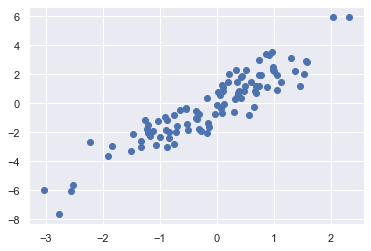

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot styling

plt.scatter(X[:, 0], X[:, 1]);

Let's use fancy indexing to select 20 random points. We'll do this by first choosing 20 random indices with no repeats, and use these indices to select a portion of the original array:

In [108]:
indices = np.random.choice(X.shape[0], 20, replace=False)
indices

array([60, 80, 95, 33, 12, 25, 20, 50,  8, 72, 70, 51, 59, 92, 45, 21, 49,
       42, 73,  2])

In [109]:
selection = X[indices]  # fancy indexing here
selection.shape

(20, 2)

Now to see which points were selected, let's over-plot large circles at the locations of the selected points:

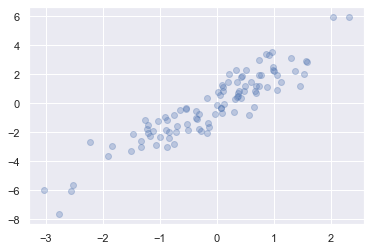

In [110]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
plt.scatter(selection[:, 0], selection[:, 1],
            facecolor='none', s=200);

This sort of strategy is often used to quickly partition datasets, as is often needed in train/test splitting for validation of statistical models (see [Hyperparameters and Model Validation](05.03-Hyperparameters-and-Model-Validation.ipynb)), and in sampling approaches to answering statistical questions.

## Modifying Values with Fancy Indexing

Just as fancy indexing can be used to access parts of an array, it can also be used to modify parts of an array.
For example, imagine we have an array of indices and we'd like to set the corresponding items in an array to some value:

In [111]:
x = np.arange(10)
i = np.array([2, 1, 8, 4])
x[i] = 99
print(x)

[ 0 99 99  3 99  5  6  7 99  9]


We can use any assignment-type operator for this. For example:

In [112]:
x[i] -= 10
print(x)

[ 0 89 89  3 89  5  6  7 89  9]


Notice, though, that repeated indices with these operations can cause some potentially unexpected results. Consider the following:

In [113]:
x = np.zeros(10)
x[[0, 0]] = [4, 6]
print(x)

[6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Where did the 4 go? The result of this operation is to first assign ``x[0] = 4``, followed by ``x[0] = 6``.
The result, of course, is that ``x[0]`` contains the value 6.

Fair enough, but consider this operation:

In [114]:
i = [2, 3, 3, 4, 4, 4]
x[i] += 1
x

array([6., 0., 1., 1., 1., 0., 0., 0., 0., 0.])

You might expect that ``x[3]`` would contain the value 2, and ``x[4]`` would contain the value 3, as this is how many times each index is repeated. Why is this not the case?
Conceptually, this is because ``x[i] += 1`` is meant as a shorthand of ``x[i] = x[i] + 1``. ``x[i] + 1`` is evaluated, and then the result is assigned to the indices in x.
With this in mind, it is not the augmentation that happens multiple times, but the assignment, which leads to the rather nonintuitive results.

So what if you want the other behavior where the operation is repeated? For this, you can use the ``at()`` method of ufuncs (available since NumPy 1.8), and do the following:

In [115]:
x = np.zeros(10)
np.add.at(x, i, 1)
print(x)

[0. 0. 1. 2. 3. 0. 0. 0. 0. 0.]


The ``at()`` method does an in-place application of the given operator at the specified indices (here, ``i``) with the specified value (here, 1).
Another method that is similar in spirit is the ``reduceat()`` method of ufuncs, which you can read about in the NumPy documentation.

## Example: Binning Data

You can use these ideas to efficiently bin data to create a histogram by hand.
For example, imagine we have 1,000 values and would like to quickly find where they fall within an array of bins.
We could compute it using ``ufunc.at`` like this:

In [116]:
np.random.seed(42)
x = np.random.randn(100)

# compute a histogram by hand
bins = np.linspace(-5, 5, 20)
counts = np.zeros_like(bins)

# find the appropriate bin for each x
i = np.searchsorted(bins, x)

# add 1 to each of these bins
np.add.at(counts, i, 1)

The counts now reflect the number of points within each bin–in other words, a histogram:

<ipython-input-117-96f9e174e9cc>:2: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
  plt.plot(bins, counts, linestyle='steps');


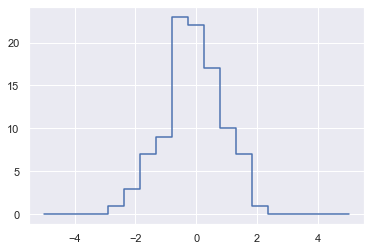

In [117]:
# plot the results
plt.plot(bins, counts, linestyle='steps');

Of course, it would be silly to have to do this each time you want to plot a histogram.
This is why Matplotlib provides the ``plt.hist()`` routine, which does the same in a single line:

```python
plt.hist(x, bins, histtype='step');
```

This function will create a nearly identical plot to the one seen here.
To compute the binning, ``matplotlib`` uses the ``np.histogram`` function, which does a very similar computation to what we did before. Let's compare the two here:

In [118]:
print("NumPy routine:")
%timeit counts, edges = np.histogram(x, bins)

print("Custom routine:")
%timeit np.add.at(counts, np.searchsorted(bins, x), 1)

NumPy routine:
29.2 µs ± 2.55 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
Custom routine:
15.3 µs ± 270 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Our own one-line algorithm is several times faster than the optimized algorithm in NumPy! How can this be?
If you dig into the ``np.histogram`` source code (you can do this in IPython by typing ``np.histogram??``), you'll see that it's quite a bit more involved than the simple search-and-count that we've done; this is because NumPy's algorithm is more flexible, and particularly is designed for better performance when the number of data points becomes large:

In [119]:
x = np.random.randn(1000000)
print("NumPy routine:")
%timeit counts, edges = np.histogram(x, bins)

print("Custom routine:")
%timeit np.add.at(counts, np.searchsorted(bins, x), 1)

NumPy routine:
67.9 ms ± 682 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Custom routine:
120 ms ± 7.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


What this comparison shows is that algorithmic efficiency is almost never a simple question. An algorithm efficient for large datasets will not always be the best choice for small datasets, and vice versa (see [Big-O Notation](02.08-Sorting.ipynb#Aside:-Big-O-Notation)).
But the advantage of coding this algorithm yourself is that with an understanding of these basic methods, you could use these building blocks to extend this to do some very interesting custom behaviors.
The key to efficiently using Python in data-intensive applications is knowing about general convenience routines like ``np.histogram`` and when they're appropriate, but also knowing how to make use of lower-level functionality when you need more pointed behavior.

# Sorting Arrays

Up to this point we have been concerned mainly with tools to access and operate on array data with NumPy.
This section covers algorithms related to sorting values in NumPy arrays.
These algorithms are a favorite topic in introductory computer science courses: if you've ever taken one, you probably have had dreams (or, depending on your temperament, nightmares) about *insertion sorts*, *selection sorts*, *merge sorts*, *quick sorts*, *bubble sorts*, and many, many more.
All are means of accomplishing a similar task: sorting the values in a list or array.

For example, a simple *selection sort* repeatedly finds the minimum value from a list, and makes swaps until the list is sorted. We can code this in just a few lines of Python:

In [120]:
import numpy as np

def selection_sort(x):
    for i in range(len(x)):
        swap = i + np.argmin(x[i:])
        (x[i], x[swap]) = (x[swap], x[i])
    return x

In [121]:
x = np.array([2, 1, 4, 3, 5])
selection_sort(x)

array([1, 2, 3, 4, 5])

As any first-year computer science major will tell you, the selection sort is useful for its simplicity, but is much too slow to be useful for larger arrays.
For a list of $N$ values, it requires $N$ loops, each of which does on order $\sim N$ comparisons to find the swap value.
In terms of the "big-O" notation often used to characterize these algorithms (see [Big-O Notation](#Aside:-Big-O-Notation)), selection sort averages $\mathcal{O}[N^2]$: if you double the number of items in the list, the execution time will go up by about a factor of four.

Even selection sort, though, is much better than my all-time favorite sorting algorithms, the *bogosort*:

In [122]:
def bogosort(x):
    while np.any(x[:-1] > x[1:]):
        np.random.shuffle(x)
    return x

In [123]:
x = np.array([2, 1, 4, 3, 5])
bogosort(x)

array([1, 2, 3, 4, 5])

This silly sorting method relies on pure chance: it repeatedly applies a random shuffling of the array until the result happens to be sorted.
With an average scaling of $\mathcal{O}[N \times N!]$, (that's *N* times *N* factorial) this should–quite obviously–never be used for any real computation.

Fortunately, Python contains built-in sorting algorithms that are *much* more efficient than either of the simplistic algorithms just shown. We'll start by looking at the Python built-ins, and then take a look at the routines included in NumPy and optimized for NumPy arrays.

## Fast Sorting in NumPy: ``np.sort`` and ``np.argsort``

Although Python has built-in ``sort`` and ``sorted`` functions to work with lists, we won't discuss them here because NumPy's ``np.sort`` function turns out to be much more efficient and useful for our purposes.
By default ``np.sort`` uses an $\mathcal{O}[N\log N]$, *quicksort* algorithm, though *mergesort* and *heapsort* are also available. For most applications, the default quicksort is more than sufficient.

To return a sorted version of the array without modifying the input, you can use ``np.sort``:

In [124]:
x = np.array([2, 1, 4, 3, 5])
np.sort(x)

array([1, 2, 3, 4, 5])

If you prefer to sort the array in-place, you can instead use the ``sort`` method of arrays:

In [125]:
x.sort()
print(x)

[1 2 3 4 5]


A related function is ``argsort``, which instead returns the *indices* of the sorted elements:

In [126]:
x = np.array([2, 1, 4, 3, 5])
i = np.argsort(x)
print(i)

[1 0 3 2 4]


The first element of this result gives the index of the smallest element, the second value gives the index of the second smallest, and so on.
These indices can then be used (via fancy indexing) to construct the sorted array if desired:

In [127]:
x[i]

array([1, 2, 3, 4, 5])

### Sorting along rows or columns

A useful feature of NumPy's sorting algorithms is the ability to sort along specific rows or columns of a multidimensional array using the ``axis`` argument. For example:

In [128]:
rand = np.random.RandomState(42)
X = rand.randint(0, 10, (4, 6))
print(X)

[[6 3 7 4 6 9]
 [2 6 7 4 3 7]
 [7 2 5 4 1 7]
 [5 1 4 0 9 5]]


In [129]:
# sort each column of X
np.sort(X, axis=0)

array([[2, 1, 4, 0, 1, 5],
       [5, 2, 5, 4, 3, 7],
       [6, 3, 7, 4, 6, 7],
       [7, 6, 7, 4, 9, 9]])

In [130]:
# sort each row of X
np.sort(X, axis=1)

array([[3, 4, 6, 6, 7, 9],
       [2, 3, 4, 6, 7, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 5, 9]])

Keep in mind that this treats each row or column as an independent array, and any relationships between the row or column values will be lost!

## Partial Sorts: Partitioning

Sometimes we're not interested in sorting the entire array, but simply want to find the *k* smallest values in the array. NumPy provides this in the ``np.partition`` function. ``np.partition`` takes an array and a number *K*; the result is a new array with the smallest *K* values to the left of the partition, and the remaining values to the right, in arbitrary order:

In [131]:
x = np.array([7, 2, 3, 1, 6, 5, 4])
np.partition(x, 3)

array([2, 1, 3, 4, 6, 5, 7])

Note that the first three values in the resulting array are the three smallest in the array, and the remaining array positions contain the remaining values.
Within the two partitions, the elements have arbitrary order.

Similarly to sorting, we can partition along an arbitrary axis of a multidimensional array:

In [132]:
np.partition(X, 2, axis=1)

array([[3, 4, 6, 7, 6, 9],
       [2, 3, 4, 7, 6, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 9, 5]])

The result is an array where the first two slots in each row contain the smallest values from that row, with the remaining values filling the remaining slots.

Finally, just as there is a ``np.argsort`` that computes indices of the sort, there is a ``np.argpartition`` that computes indices of the partition.
We'll see this in action in the following section.

## Example: k-Nearest Neighbors

Let's quickly see how we might use this ``argsort`` function along multiple axes to find the nearest neighbors of each point in a set.
We'll start by creating a random set of 10 points on a two-dimensional plane.
Using the standard convention, we'll arrange these in a $10\times 2$ array:

In [133]:
X = rand.rand(10, 2)

To get an idea of how these points look, let's quickly scatter plot them:

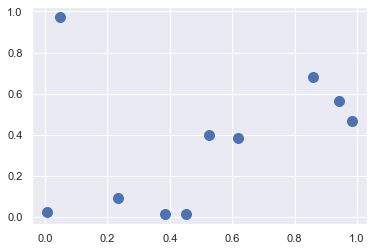

In [134]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # Plot styling
plt.scatter(X[:, 0], X[:, 1], s=100);

Now we'll compute the distance between each pair of points.
Recall that the squared-distance between two points is the sum of the squared differences in each dimension;
using the efficient broadcasting ([Computation on Arrays: Broadcasting](02.05-Computation-on-arrays-broadcasting.ipynb)) and aggregation ([Aggregations: Min, Max, and Everything In Between](02.04-Computation-on-arrays-aggregates.ipynb))  routines provided by NumPy we can compute the matrix of square distances in a single line of code:

In [135]:
dist_sq = np.sum((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2, axis=-1)

This operation has a lot packed into it, and it might be a bit confusing if you're unfamiliar with NumPy's broadcasting rules. When you come across code like this, it can be useful to break it down into its component steps:

In [136]:
# for each pair of points, compute differences in their coordinates
differences = X[:, np.newaxis, :] - X[np.newaxis, :, :]
differences.shape

(10, 10, 2)

In [137]:
# square the coordinate differences
sq_differences = differences ** 2
sq_differences.shape

(10, 10, 2)

In [138]:
# sum the coordinate differences to get the squared distance
dist_sq = sq_differences.sum(-1)
dist_sq.shape

(10, 10)

Just to double-check what we are doing, we should see that the diagonal of this matrix (i.e., the set of distances between each point and itself) is all zero:

In [139]:
dist_sq.diagonal()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

It checks out!
With the pairwise square-distances converted, we can now use ``np.argsort`` to sort along each row. The leftmost columns will then give the indices of the nearest neighbors:

In [140]:
nearest = np.argsort(dist_sq, axis=1)
print(nearest)

[[0 3 9 7 1 4 2 5 6 8]
 [1 4 7 9 3 6 8 5 0 2]
 [2 1 4 6 3 0 8 9 7 5]
 [3 9 7 0 1 4 5 8 6 2]
 [4 1 8 5 6 7 9 3 0 2]
 [5 8 6 4 1 7 9 3 2 0]
 [6 8 5 4 1 7 9 3 2 0]
 [7 9 3 1 4 0 5 8 6 2]
 [8 5 6 4 1 7 9 3 2 0]
 [9 7 3 0 1 4 5 8 6 2]]


Notice that the first column gives the numbers 0 through 9 in order: this is due to the fact that each point's closest neighbor is itself, as we would expect.

By using a full sort here, we've actually done more work than we need to in this case. If we're simply interested in the nearest $k$ neighbors, all we need is to partition each row so that the smallest $k + 1$ squared distances come first, with larger distances filling the remaining positions of the array. We can do this with the ``np.argpartition`` function:

In [141]:
K = 2
nearest_partition = np.argpartition(dist_sq, K + 1, axis=1)

In order to visualize this network of neighbors, let's quickly plot the points along with lines representing the connections from each point to its two nearest neighbors:

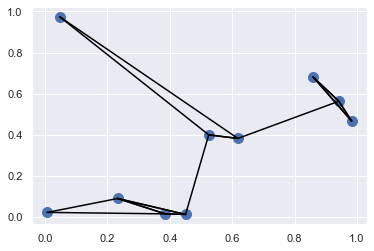

In [142]:
plt.scatter(X[:, 0], X[:, 1], s=100)

# draw lines from each point to its two nearest neighbors
K = 2

for i in range(X.shape[0]):
    for j in nearest_partition[i, :K+1]:
        # plot a line from X[i] to X[j]
        # use some zip magic to make it happen:
        plt.plot(*zip(X[j], X[i]), color='black')

Each point in the plot has lines drawn to its two nearest neighbors.
At first glance, it might seem strange that some of the points have more than two lines coming out of them: this is due to the fact that if point A is one of the two nearest neighbors of point B, this does not necessarily imply that point B is one of the two nearest neighbors of point A.

Although the broadcasting and row-wise sorting of this approach might seem less straightforward than writing a loop, it turns out to be a very efficient way of operating on this data in Python.
You might be tempted to do the same type of operation by manually looping through the data and sorting each set of neighbors individually, but this would almost certainly lead to a slower algorithm than the vectorized version we used. The beauty of this approach is that it's written in a way that's agnostic to the size of the input data: we could just as easily compute the neighbors among 100 or 1,000,000 points in any number of dimensions, and the code would look the same.

Finally, I'll note that when doing very large nearest neighbor searches, there are tree-based and/or approximate algorithms that can scale as $\mathcal{O}[N\log N]$ or better rather than the $\mathcal{O}[N^2]$ of the brute-force algorithm. One example of this is the KD-Tree, [implemented in Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html).